In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/output1/model_epoch_2025-04-08_15-33-00_8.pth
/kaggle/input/model2/model_epoch_10.pth


In [2]:
checkpoint_path="/kaggle/input/model2/model_epoch_10.pth"


In [3]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, Dinov2Model


class MLP(nn.Module):
    def __init__(self, dim, n_class, dino):
        super().__init__()
        self.dino =dino
        self.dino.eval()
        self.mlp = nn.Linear(dim, n_class)
        self.h_dim=dim
    def forward(self, inp):
        with torch.no_grad():
            B,C,T,H,W = inp.shape
            inp = inp.transpose(1,2).reshape(B*T,C,H,W)
            output = self.dino(inp).last_hidden_state

        output = output[:, 0, :]
        # print(output.shape)
        output = output.reshape(B,T,-1)
        # print(output.shape)
        output = output.mean(dim=-2)
        # print(output.shape)


        output = self.mlp(output) # b d -> b l
        # print(f"{output.shape=}")
        return output


In [4]:
checkpoint=torch.load(checkpoint_path,map_location="cpu")
dino= Dinov2Model.from_pretrained('facebook/dinov2-base')
model = MLP(768, 101,dino)
model.load_state_dict(checkpoint)
model.to("cuda")

<ipython-input-4-8a64baa7754e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(checkpoint_path,map_location="cpu")


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

MLP(
  (dino): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )


In [5]:
pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 98.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torchvision.transforms as transforms
import decord
from decord import VideoReader, cpu
from PIL import Image
import numpy as np

# Set decord backend
decord.bridge.set_bridge('native')

# ----------------------------
# Define transformation
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

# ----------------------------
# Load class index to label mapping
# ----------------------------
def load_class_mapping(classInd_path):
    with open(classInd_path, 'r') as f:
        return {int(line.split()[0]) - 1: line.strip().split()[1] for line in f}

# ----------------------------
# Load and preprocess video
# ----------------------------
def load_video_clip(video_path, frames_per_clip=8):
    vr = VideoReader(video_path, ctx=cpu(0))
    nframes = len(vr)

    if nframes <= frames_per_clip:
        idxs = np.arange(frames_per_clip) % nframes
    else:
        idxs = np.linspace(0, nframes - 1, frames_per_clip).astype(int)

    frames = [transform(Image.fromarray(vr[i].asnumpy())) for i in idxs]
    clip = torch.stack(frames, dim=1)  # [C, T, H, W]
    return clip.unsqueeze(0)  # [1, C, T, H, W]

def predict_class(video_path, model, classInd_path, device='cuda'):
    model.eval()
    model.to(device)

    clip = load_video_clip(video_path).to(device)
    with torch.no_grad():
        logits = model(clip)
        predicted_class = torch.argmax(logits, dim=1).item()

    class_map = load_class_mapping(classInd_path)
    return class_map[predicted_class]


In [7]:
!apt install aria2


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 129 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 1s (1,889 kB/s)

78Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 127400 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
7Progress: [  0%] [..............

In [8]:
!wget --no-check-certificate -P /kaggle/working https://www.crcv.ucf.edu/data/UCF101/UCF101.rar


--2025-04-16 09:07:03--  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 6932971618 (6.5G) [application/x-rar-compressed]
Saving to: ‘/kaggle/working/UCF101.rar’

UCF101.rar          100%[===================>]   6.46G  29.0MB/s    in 3m 57s  

2025-04-16 09:11:00 (27.9 MB/s) - ‘/kaggle/working/UCF101.rar’ saved [6932971618/6932971618]



In [9]:
!git clone https://github.com/BhashkarKumar2/anomally_detection

Cloning into 'anomally_detection'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 105.41 KiB | 11.71 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [10]:
class_ind="/kaggle/working/anomally_detection/testlabels/classInd.txt"



In [ ]:
!pip install decord

In [ ]:
!unrar x UCF101.rar

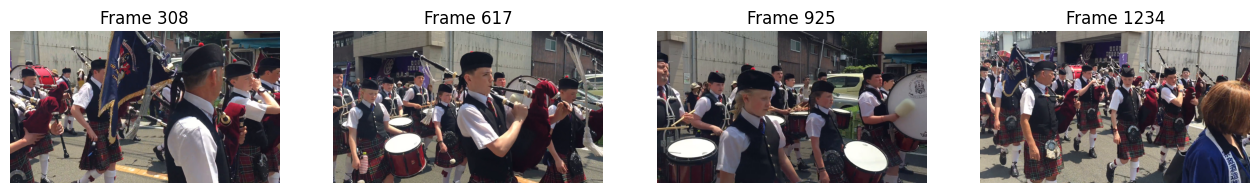

In [46]:
from decord import VideoReader, cpu
from PIL import Image
import matplotlib.pyplot as plt

# video_path = "UCF-101/Archery/v_Archery_g19_c02.avi"
# video_path="UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi"
# video_path="/kaggle/working/UCF-101/BandMarching/v_BandMarching_g01_c03.avi"
# video_path="/kaggle/working/UCF-101/Basketball/v_Basketball_g01_c01.avi"
# video_path="/kaggle/working/UCF-101/BabyCrawling/v_BabyCrawling_g01_c01.avi"
# video_path="/kaggle/working/UCF-101/Bowling/v_Bowling_g01_c01.avi"
# video_path = "/kaggle/input/data23/6603067-hd_1080_1920_25fps (1).avi"
video_path = "/kaggle/input/bandtemp/band video (2).avi"


vr = VideoReader(video_path, ctx=cpu(0))
total_frames = len(vr)

# Get 4 equally spaced frame indices
indices = [int(i * total_frames / 5) for i in range(1, 5)]  # 4 frames

plt.figure(figsize=(16, 4))
for idx, frame_idx in enumerate(indices):
    frame = vr[frame_idx].asnumpy()
    plt.subplot(1, 4, idx + 1)
    plt.imshow(frame)
    plt.title(f"Frame {frame_idx}")
    plt.axis("off")
plt.show()



In [47]:
predicted_label = predict_class(video_path, model, class_ind, device='cuda')


In [48]:
print(predicted_label)

BandMarching
